<h1 ><big><center>MSO 3.4 - Deep Structured Learning</center></big></h1>

<h2><big><center> BE 2 - GANs and Diffusion </center></big></h2>

<h5><center>GANs section adapted from the <i>Projet d'Option</i> of : Mhamed Jabri, Martin Chauvin, Ahmed Sahraoui, Zakariae Moustaïne and Taoufik Bouchikhi  
<h5><center>Diffusion section implemented by Bruno Machado<br>


<p align="center">
<img height=300px src="https://cdn-images-1.medium.com/max/1080/0*tJRy5Chmk4XymxwN.png"/></p>
<p align="center"></p>

# Part 3 bis: Conditional Diffusion

https://huggingface.co/learn/diffusion-course/unit2/3

In [1]:
# TODO: change the variable name to match the one you used in part 1 or reload the dataset

# Import required libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

image_size, batch_size, num_epochs = 64, 128, 5 # 1h to train
image_size, batch_size, num_epochs = 16, 1024,10 # 5min to train but not good
image_size, batch_size, num_epochs = 16, 512, 20 # 9min to train good with scheduler
image_size, batch_size, num_epochs = 16, 512, 10 # 5min to train good with scheduler


# Download MNIST Dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download training data
mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download test data
mnist_test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
def plot1xNArray(images, labels):
    f, axarr = plt.subplots(1, len(images))

    for image, ax, label in zip(images, axarr, labels):
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(label)

In order to train the model with the diffusion process, we will use a noise scheduler, which will be in charge of the forward diffusion process. The scheduler takes an image, a sample of random noise and a timestep, and return a noisy image for the corresponding timestep. Noise is progressvely added to the image at each timestep, therefore a noisy image at timestep 0 will have barely any noise while a noisy image at the maximum timestep will be basically just noise.  

Let's create a noise scheduler with 1000 max timesteps and visualize some noise images.  

We will use the diffusers library, which provides several tools for training and using diffusion models.  

In [3]:
def reverse_transform(image):
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)

    return image

device = torch.device("mps") if torch.backends.mps.is_available() else "cuda"

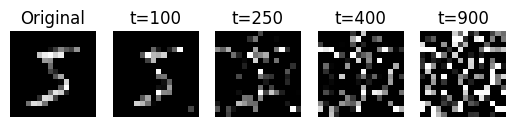

In [4]:
from diffusers import DDPMScheduler

# TODO: Create the scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="linear",
    clip_sample=False,
)

image, _ = mnist_dataset[0]

# TODO: Create a noise tensor sampled from a normal distribution with the same shape as the image
noise = torch.randn_like(image)

images, labels = [reverse_transform(image)], ["Original"]

for i in [100, 250, 400, 900]:
    timestep = torch.LongTensor([i])
    noisy_image = noise_scheduler.add_noise(image, noise, timestep)
    images.append(reverse_transform(noisy_image))
    labels.append(f"t={i}")

plot1xNArray(images, labels)

For the reverse diffusion process we will use a neural network. Given a noisy image and the corresponding timestep, the goal of the neural network is to predict the noise, which allows for the denoising.  

For the model, we will have a similar architecture as we used for the cGAN generator, a 2D UNet with a few modifications. The main difference will be that we have to indicate to the model which timestep is currently being denoised. For that purpose a timestep embedding is added, therefore the model has 2 inputs, the noisy image and the corresponding timestep.  
  
In this exercise, we will use an UNet implementation from the diffusers library, which already has the timestep embedding included.

In [ ]:
import torch.nn as nn
from diffusers import UNet2DModel, UNet2DConditionModel

class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=28,  # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels for class cond.
            out_channels=1,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = self.class_emb(class_labels)  # Map to embedding dimension
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 5, 28, 28)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)

In [ ]:
# TODO: Complete the parameters
conditional_unet = ClassConditionedUnet().to(device)

# Optimizer
optimizer = torch.optim.AdamW(conditional_unet.parameters(), lr=1e-4)

# print(conditional_unet)

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.AdamW(conditional_unet.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(
    optimizer,
    T_max = num_epochs,   # how many epochs before annealing to the minimum
    eta_min = 1e-5,       # final (lowest) LR
)

In [ ]:
# ----------------
#  Training Loop
# ----------------
torch.backends.cudnn.deterministic = True


losses = []
# num_epochs = 5
print_every = 100

conditional_unet.train()

for epoch in range(num_epochs):
    for i, batch in enumerate(mnist_dataloader):
        # Zero the gradients
        optimizer.zero_grad()

        # Send input to device
        images = batch[0].to(device)

        # Send labels to device
        labels = batch[1].to(device)

        # Generate noisy images, different timestep for each image in the batch
        timesteps = torch.randint(noise_scheduler.config.num_train_timesteps, (images.size(0),), device=device)

        # TODO: Complete the code
        noise = torch.randn_like(images)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        noisy_images = noisy_images.to(device)


        # Forward pass
        residual = conditional_unet(
            noisy_images,
            timesteps,
            labels
        )

        # TODO: Compute the loss
        loss = torch.nn.functional.mse_loss(residual, noise)

        loss.backward()
        optimizer.step()

        # Print stats
        if i % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}][{i}/{len(mnist_dataloader)}] | loss: {loss.item():6.4f}')
    scheduler.step()
    losses.append(loss.item())
    torch.save(conditional_unet.state_dict(), f"conditional_diffusion_{epoch+1}.pth")

Epoch [1/10][0/118] | loss: 1.0311
Epoch [1/10][100/118] | loss: 0.0658
Epoch [2/10][0/118] | loss: 0.0574
Epoch [2/10][100/118] | loss: 0.0452
Epoch [3/10][0/118] | loss: 0.0456
Epoch [3/10][100/118] | loss: 0.0427
Epoch [4/10][0/118] | loss: 0.0440
Epoch [4/10][100/118] | loss: 0.0380
Epoch [5/10][0/118] | loss: 0.0353
Epoch [5/10][100/118] | loss: 0.0345
Epoch [6/10][0/118] | loss: 0.0355
Epoch [6/10][100/118] | loss: 0.0345
Epoch [7/10][0/118] | loss: 0.0328
Epoch [7/10][100/118] | loss: 0.0339
Epoch [8/10][0/118] | loss: 0.0316
Epoch [8/10][100/118] | loss: 0.0302
Epoch [9/10][0/118] | loss: 0.0334
Epoch [9/10][100/118] | loss: 0.0336
Epoch [10/10][0/118] | loss: 0.0315
Epoch [10/10][100/118] | loss: 0.0304


If the training takes too long, you can download an already trained model from [this link](https://partage.liris.cnrs.fr/index.php/s/AP2t6b3w8SM4Bp5) and use it for inference.

In [ ]:
# TODO: Add the path to the model checkpoint for loading the model

conditional_unet.load_state_dict(torch.load("conditional_diffusion_10.pth"))
# conditional_unet.eval()

<All keys matched successfully>

Time to generate some images.  

During training, for each data sample, we take a random timestep and correspondent noisy image to give it as input to our model. With suffitient training, the model should learn how to predict the noise in a noisy image for all possible timesteps.  

During inference, to generate an image, we will start from pure noise and step by step predict the noise to go from one noisy image to the next, progressively denoising the image until we reach the timestep 0, in which we should have an image without any noise.

100%|██████████| 1000/1000 [00:20<00:00, 47.65it/s]


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


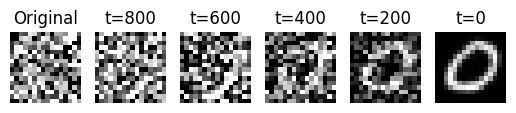

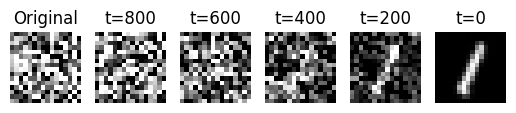

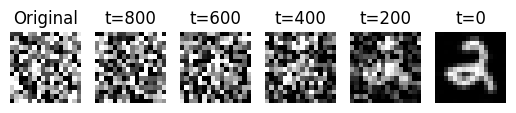

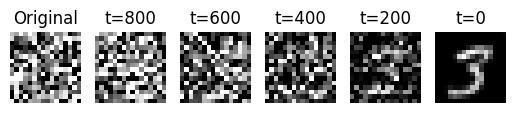

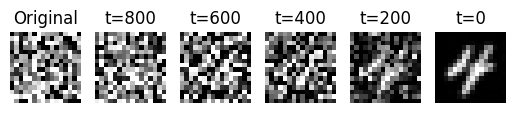

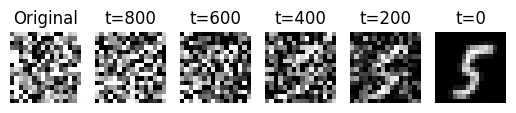

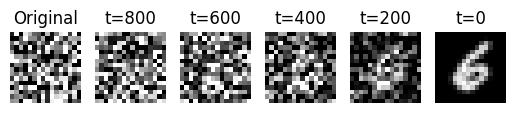

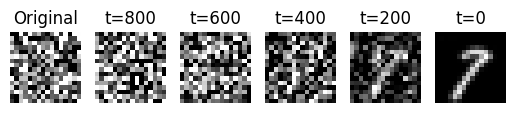

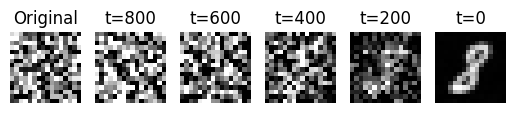

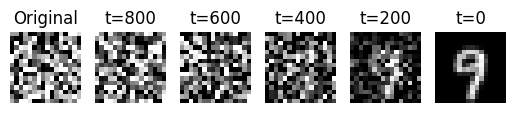

In [10]:
from tqdm import tqdm

# Set seed
torch.manual_seed(0)

# Start the image as random noise
image = torch.randn((10, 1, image_size, image_size)).to(device)

# Create a list of images and labels for visualization
images, labels = [(image / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy()], ["Original"]

# Use the scheduler to iterate over timesteps
noise_scheduler.set_timesteps(1000)

class_labels = torch.arange(10).to(device)
for timestep in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = conditional_unet(image, timestep, class_labels)
        image = noise_scheduler.step(residual, timestep, image).prev_sample

    if timestep.item() % 200 == 0:
        images.append((image / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy())
        labels.append(f"t={timestep.item()}")

print(class_labels)
for i in range(images[0].shape[0]):
    plot1xNArray([img[i] for img in images], labels)